## Import

In [2]:
# Import
import glob
import timeit
import re
from scipy.misc import imread
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline 
import sys
sys.path.append('..')

## Doc finder

In [3]:
def doc_finder_handle(basepath, fileformat):
    """
    Finds files of a particular format in the basepath.
    """
    # place holder
    docs = []

    # Loop over files
    for each_file in glob.glob(basepath + '/*.' + fileformat):
        docs.append(each_file)

    # return docs
    return docs

In [4]:
docs = doc_finder_handle('../data/bibtex/train', 'txt')
print(docs) 

['../data/bibtex/train\\anthropology.txt', '../data/bibtex/train\\ecology.txt', '../data/bibtex/train\\economics.txt', '../data/bibtex/train\\evolution.txt']


## Text File Splitter

Bibtex citation exports are compiled in a single txt document. A procedure is required to split the document into pieces before processing.

In [5]:
# loop and split
def bibtex_splitter(file):
    """
    Summary
    --------
    Helper function to splitter text document into citation articles 
    and process hard coded parameters. The input txt file needs to be 
    a set of citations downloaded in Bibtex format. There are specific 
    patterns that are looked for to split the text document such as 
    the @article value to separate the primary content. Returns a list 
    of dictionaries containing all of the keywords defined in this method.
    
    Parameters
    -----------
    arg1: txt file 
    
    Usage
    -----
    text = open('data/more_citations.txt', 'r') 
    bibtex_splitter(text)
    
    Example data
    -------------
    
    
    Returns
    ---------
    
    """
    # Placeholder
    textcapture = []
    
    # List of items to collect
    items = ['ISSN =', 'abstract =', 'author =', 'journal =', 'number =', 
         'pages =', 'publisher=', 'title=', 'volume=', 'year=']
    
    # Loop over the file (txt file)
    for doc in file.read().split('@'):
        temp = {}
        for item in items:
            m = re.search(item, doc)
            try:
                item_end = doc[m.end(): ] 
                capture = item_end[item_end.find('{') + 1 : item_end.find('}')]
                temp[item[:-2]] = capture

            except:
                pass
        
        # Add list
        textcapture.append(temp)        
        
    return textcapture

In [7]:
# open file
text = open(docs[0], 'r', encoding="utf8") 

# implement method
ts = bibtex_splitter(text)

## Review / Checks

In [8]:
print(ts[3]['author'])

Eloise Meneses and Lindy Backues and David Bronkema and Eric Flett and Benjamin L. Hartley


## Word Cleaning

In [9]:
def word_cleaning_handle(string_of_text):
    """
    Converts a string to a dictionary of words. 
    
    Parameters
    -----------
    arg1: string
    
    Usage
    ------
    word_cleaning_handle('this test')
    
    Returns
    --------
    {'this': 1, 'test': 1}
    
    Doctest
    --------
    >>> word_cleaning_handle('text65[12];:')
    {'text': 1}
    """
    # Empty dictionary
    dictionary_of_words ={}
    
    # Regex to process each word
    regex = re.compile("[%()^$0-9,'\.;:!?{}\]\[]")
    
    # loop over a string split by whitespace
    for word in string_of_text.split(' '):
    
        # implement regex from above for each word
        m = regex.sub('', word)
        
        # drop spaces and single letters 
        if len(m) > 1:
            # note the use of lower case | add words to dictionary
            dictionary_of_words[m.lower()] = dictionary_of_words.get(m.lower(), 0) + 1
            
    # Return the results
    return dictionary_of_words

## Review / Checks

In [10]:
#word_cleaning_handle('I am a string of text: This method 1. omits single letters, \
#2. strips off numbers [e.g. text999], and 3. special symbols are removed {e.g. text(1{0});}.\
#')
import doctest
doctest.testmod()

TestResults(failed=0, attempted=1)

## Word stemming

In [11]:
stemmer = SnowballStemmer("english")
stemmer.stem("Running")

'run'

## Remove Stop Words from Dictionary

In [12]:
def remove_stopwords(dictionary):
    # Placeholder for output
    stemmed_journal_words = {}
    original_journal_words = {}
    
    # pull key-value pairs from dictionary and parse out stopwords
    for key, value in dictionary.items():

        # pass on all stop words
        if re.search(r'\\', key) or key in STOPWORDS:
            pass

        else:    
            try: 
                # Add stemmed word 
                key_stem = stemmer.stem(key)
                stemmed_journal_words[key_stem] = stemmed_journal_words.get(
                    key_stem.lower(), 0) + value

            except:
                # If stemming fails enter the original word
                stemmed_journal_words[key] = stemmed_journal_words.get(
                    key.lower(), 0) + value

            finally:        
                # Add in original words        
                original_journal_words[key] = original_journal_words.get(
                    key.lower(), 0) + value
                
    return original_journal_words, stemmed_journal_words

## Review / Checks

In [13]:
remove_stopwords({"this": 1, "association": 3, "step": 5, "settings": 10})

({'association': 3, 'settings': 10, 'step': 5},
 {'associ': 3, 'set': 10, 'step': 5})

## Process text

In [16]:
def process_bibtex_citations(docs):
    """
    Parse documents containing bibtex citations.    
    """
    # place holder
    original_results = []
    stemmed_results = []
    article_details = []
    
    # loop over docs
    for each_file in docs:

        # open text file
        text = open(each_file, 'r', encoding="utf8") 
        
        # split text
        bs = bibtex_splitter(text)

        # read in each article
        for article in bs:
            
            # skip if no data
            if article == {}:
                continue
   
            else:
                try:
                    # temp palce holder
                    temp = []
                    
                    # Convert string to words dictionary
                    output_text = word_cleaning_handle(article['abstract'])
                    
                    # Drop stopwords and apply stemming
                    originalwords, stemmedwords = remove_stopwords(output_text)
                    
                    # collect article attibutes
                    article.pop('abstract', None)
                    
                    # Append results
                    original_results.append([article, originalwords])
                    stemmed_results.append([article, stemmedwords])
                    
                except:
                     pass

            # Append results
            article_details.append(article)                
                        
    return article_details, original_results, stemmed_results

In [17]:
## Run
ad, oj, sj = process_bibtex_citations(docs)

## Check the output

In [21]:
# Print length of first dictionary of words
print("Original words:", len(oj[0][1]), "| Stemmed words:", len(sj[0][1]))

Original words: 58 | Stemmed words: 55


In [22]:
ad

[{'ISSN': '00113204, 15375382',
  'author': 'Simon Coleman',
  'journal': 'Current Anthropology',
  'number': 'S10',
  'pages': 'S281-S291'},
 {'ISSN': '00113204, 15375382',
  'author': 'Eloise Meneses and Lindy Backues and David Bronkema and Eric Flett and Benjamin L. Hartley',
  'journal': 'Current Anthropology',
  'number': '1',
  'pages': '82-104'},
 {'ISSN': '01106465, 11777788',
  'author': 'Gary N. Bramley',
  'journal': 'New Zealand Journal of Ecology',
  'number': '2',
  'pages': '328-334'},
 {'ISSN': '01106465, 11777788',
  'author': 'Robert B. Schadewinkel and Alistair M. Senior and Deborah J. Wilson and Ian G. Jamieson',
  'journal': 'New Zealand Journal of Ecology',
  'number': '2',
  'pages': '315-321'},
 {'ISSN': '00220515',
  'author': 'David I. Stern',
  'journal': 'Journal of Economic Literature',
  'number': '1',
  'pages': '173-189'},
 {'ISSN': '00220515',
  'author': 'Melissa Dell and Benjamin F. Jones and Benjamin A. Olken',
  'journal': 'Journal of Economic Liter

## Process word cloud

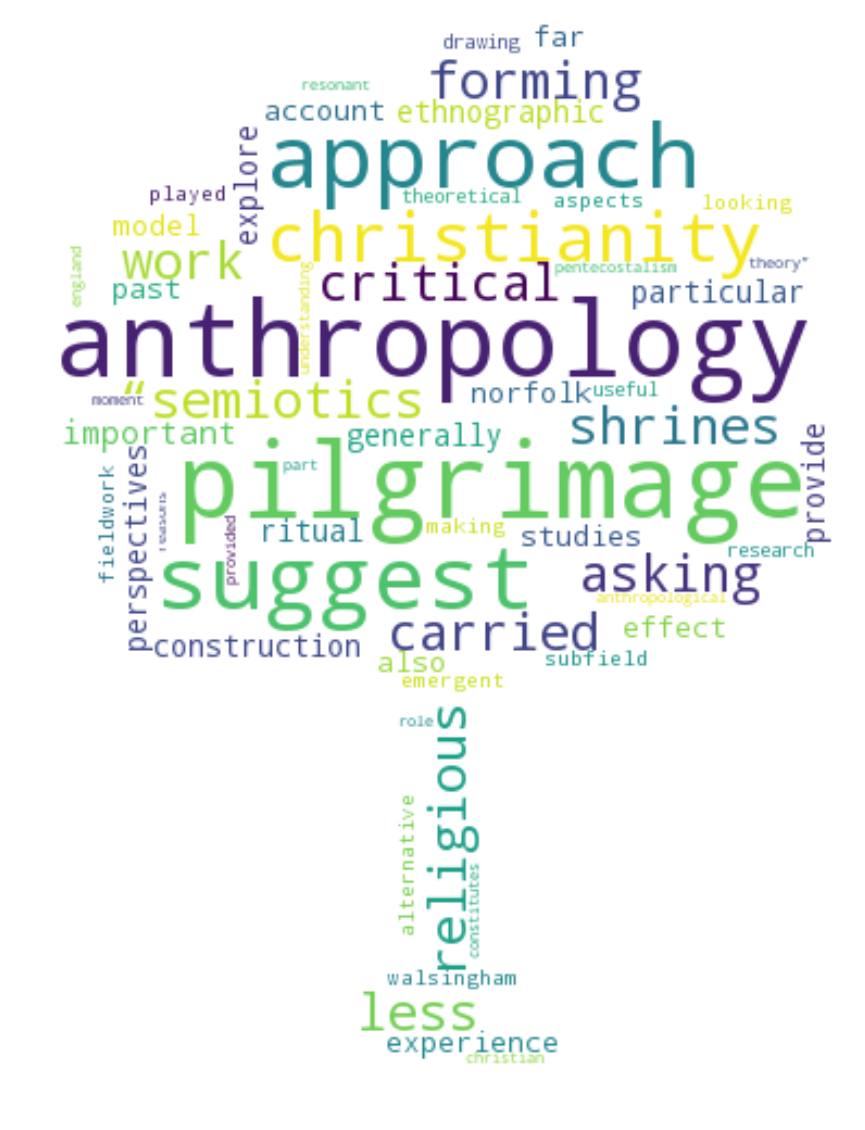

In [23]:
# Provide a mask
clip_mask = imread("../static/img/tree.png")

# Create wordcloud
wc = WordCloud(background_color="white", width=800, height=800, mask=clip_mask, max_words = 400, stopwords=STOPWORDS) 
wc.generate_from_frequencies(oj[0][1])

# Plot
plt.figure(figsize = (16,14))
plt.imshow(wc)
plt.axis("off")
plt.show

# Output to file
wc.to_file("../output/img/bibtex/tree.png") 